<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Распределения-признаков" data-toc-modified-id="Распределения-признаков-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Распределения признаков</a></span></li><li><span><a href="#Масштабирование" data-toc-modified-id="Масштабирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Масштабирование</a></span></li><li><span><a href="#Двухэтапная-модель-FAISS+CatBoost" data-toc-modified-id="Двухэтапная-модель-FAISS+CatBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Двухэтапная модель FAISS+CatBoost</a></span><ul class="toc-item"><li><span><a href="#Создание-индексов" data-toc-modified-id="Создание-индексов-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Создание индексов</a></span></li><li><span><a href="#Отбор-кандидатов-FAISS" data-toc-modified-id="Отбор-кандидатов-FAISS-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Отбор кандидатов FAISS</a></span><ul class="toc-item"><li><span><a href="#Объединим-кандидатов-в-DataFrame" data-toc-modified-id="Объединим-кандидатов-в-DataFrame-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Объединим кандидатов в DataFrame</a></span></li><li><span><a href="#Добавим-признаки" data-toc-modified-id="Добавим-признаки-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Добавим признаки</a></span></li></ul></li><li><span><a href="#Формирование-датасетов-для-обучения-катбуста" data-toc-modified-id="Формирование-датасетов-для-обучения-катбуста-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Формирование датасетов для обучения катбуста</a></span></li><li><span><a href="#Сгенерируем-новые-признаки" data-toc-modified-id="Сгенерируем-новые-признаки-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Сгенерируем новые признаки</a></span></li><li><span><a href="#Обучение-CatBoostClassifier" data-toc-modified-id="Обучение-CatBoostClassifier-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Обучение CatBoostClassifier</a></span></li><li><span><a href="#Тест-на-validation" data-toc-modified-id="Тест-на-validation-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Тест на validation</a></span><ul class="toc-item"><li><span><a href="#Отбор-кандидатов-FAISS" data-toc-modified-id="Отбор-кандидатов-FAISS-5.6.1"><span class="toc-item-num">5.6.1&nbsp;&nbsp;</span>Отбор кандидатов FAISS</a></span></li><li><span><a href="#Объединим-кандидатов-в-DataFrame" data-toc-modified-id="Объединим-кандидатов-в-DataFrame-5.6.2"><span class="toc-item-num">5.6.2&nbsp;&nbsp;</span>Объединим кандидатов в DataFrame</a></span></li><li><span><a href="#Добавим-признаки" data-toc-modified-id="Добавим-признаки-5.6.3"><span class="toc-item-num">5.6.3&nbsp;&nbsp;</span>Добавим признаки</a></span></li><li><span><a href="#Ранжирование" data-toc-modified-id="Ранжирование-5.6.4"><span class="toc-item-num">5.6.4&nbsp;&nbsp;</span>Ранжирование</a></span></li><li><span><a href="#Расчет-метрики" data-toc-modified-id="Расчет-метрики-5.6.5"><span class="toc-item-num">5.6.5&nbsp;&nbsp;</span>Расчет метрики</a></span></li></ul></li></ul></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></div>

# Matching

## Описание проекта

Есть реальные данные от одного из крупнейших маркетплейсов страны. Для каждого товара уже сформированы числовые векторы размерностью 72. Всего, наборов для обучения ~ 3 млн. 

**Цель:** разработать модель для поиска товаров, с высоким значением метрики accuracy@5 (не меньше 80%) 

**Задачи:**

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.


**Стэк:** FAISS, KNN, ранжирующие модели, индексирование в векторных базах

## Загрузка данных

In [1]:
#conda install -c conda-forge faiss

In [2]:
import pandas as pd
import faiss
import numpy as np

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
path='C:/Users/zoika/OneDrive/Рабочий стол/YP ds54/Practika/Mathing/'

In [4]:
base = pd.read_csv(path+'base.csv',index_col=0)
display(base.info())
base.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


None

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.42676,-118.88089,216.482440,-104.69806,-469.070588,44.348083,120.915344,181.44970,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.93361,115.26919,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.78761,-166.53348,57.680607,-86.09837,-85.076666,-35.637436,119.718636,195.23419,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.93793,116.83400,-84.888941,-59.524610


In [5]:
base=base.astype(np.float32)
#display(base.info())
base.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.66634,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.20211,24.346846,179.937927,116.834000,-84.888939,-59.524609


In [6]:
train = pd.read_csv(path+'train.csv',index_col=0)
#display(train.info())
display(train.shape)
train.head(2)

(100000, 73)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.91590,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base


In [7]:
train.loc[:,'0':'71']=train.loc[:,'0':'71'].astype(np.float32)
#display(train.info())
train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base


In [8]:
validation = pd.read_csv(path+'validation.csv',index_col=0)
validation=validation.astype(np.float32)
#display(validation.info())
display(validation.shape)
validation.head(2)

(100000, 72)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,...,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319


In [9]:
validation_answer = pd.read_csv(path+'validation_answer.csv',index_col=0)
display(validation_answer.shape)
validation_answer.head(2)

(100000, 1)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base


## Распределения признаков

CPU times: total: 6.84 s
Wall time: 6.98 s


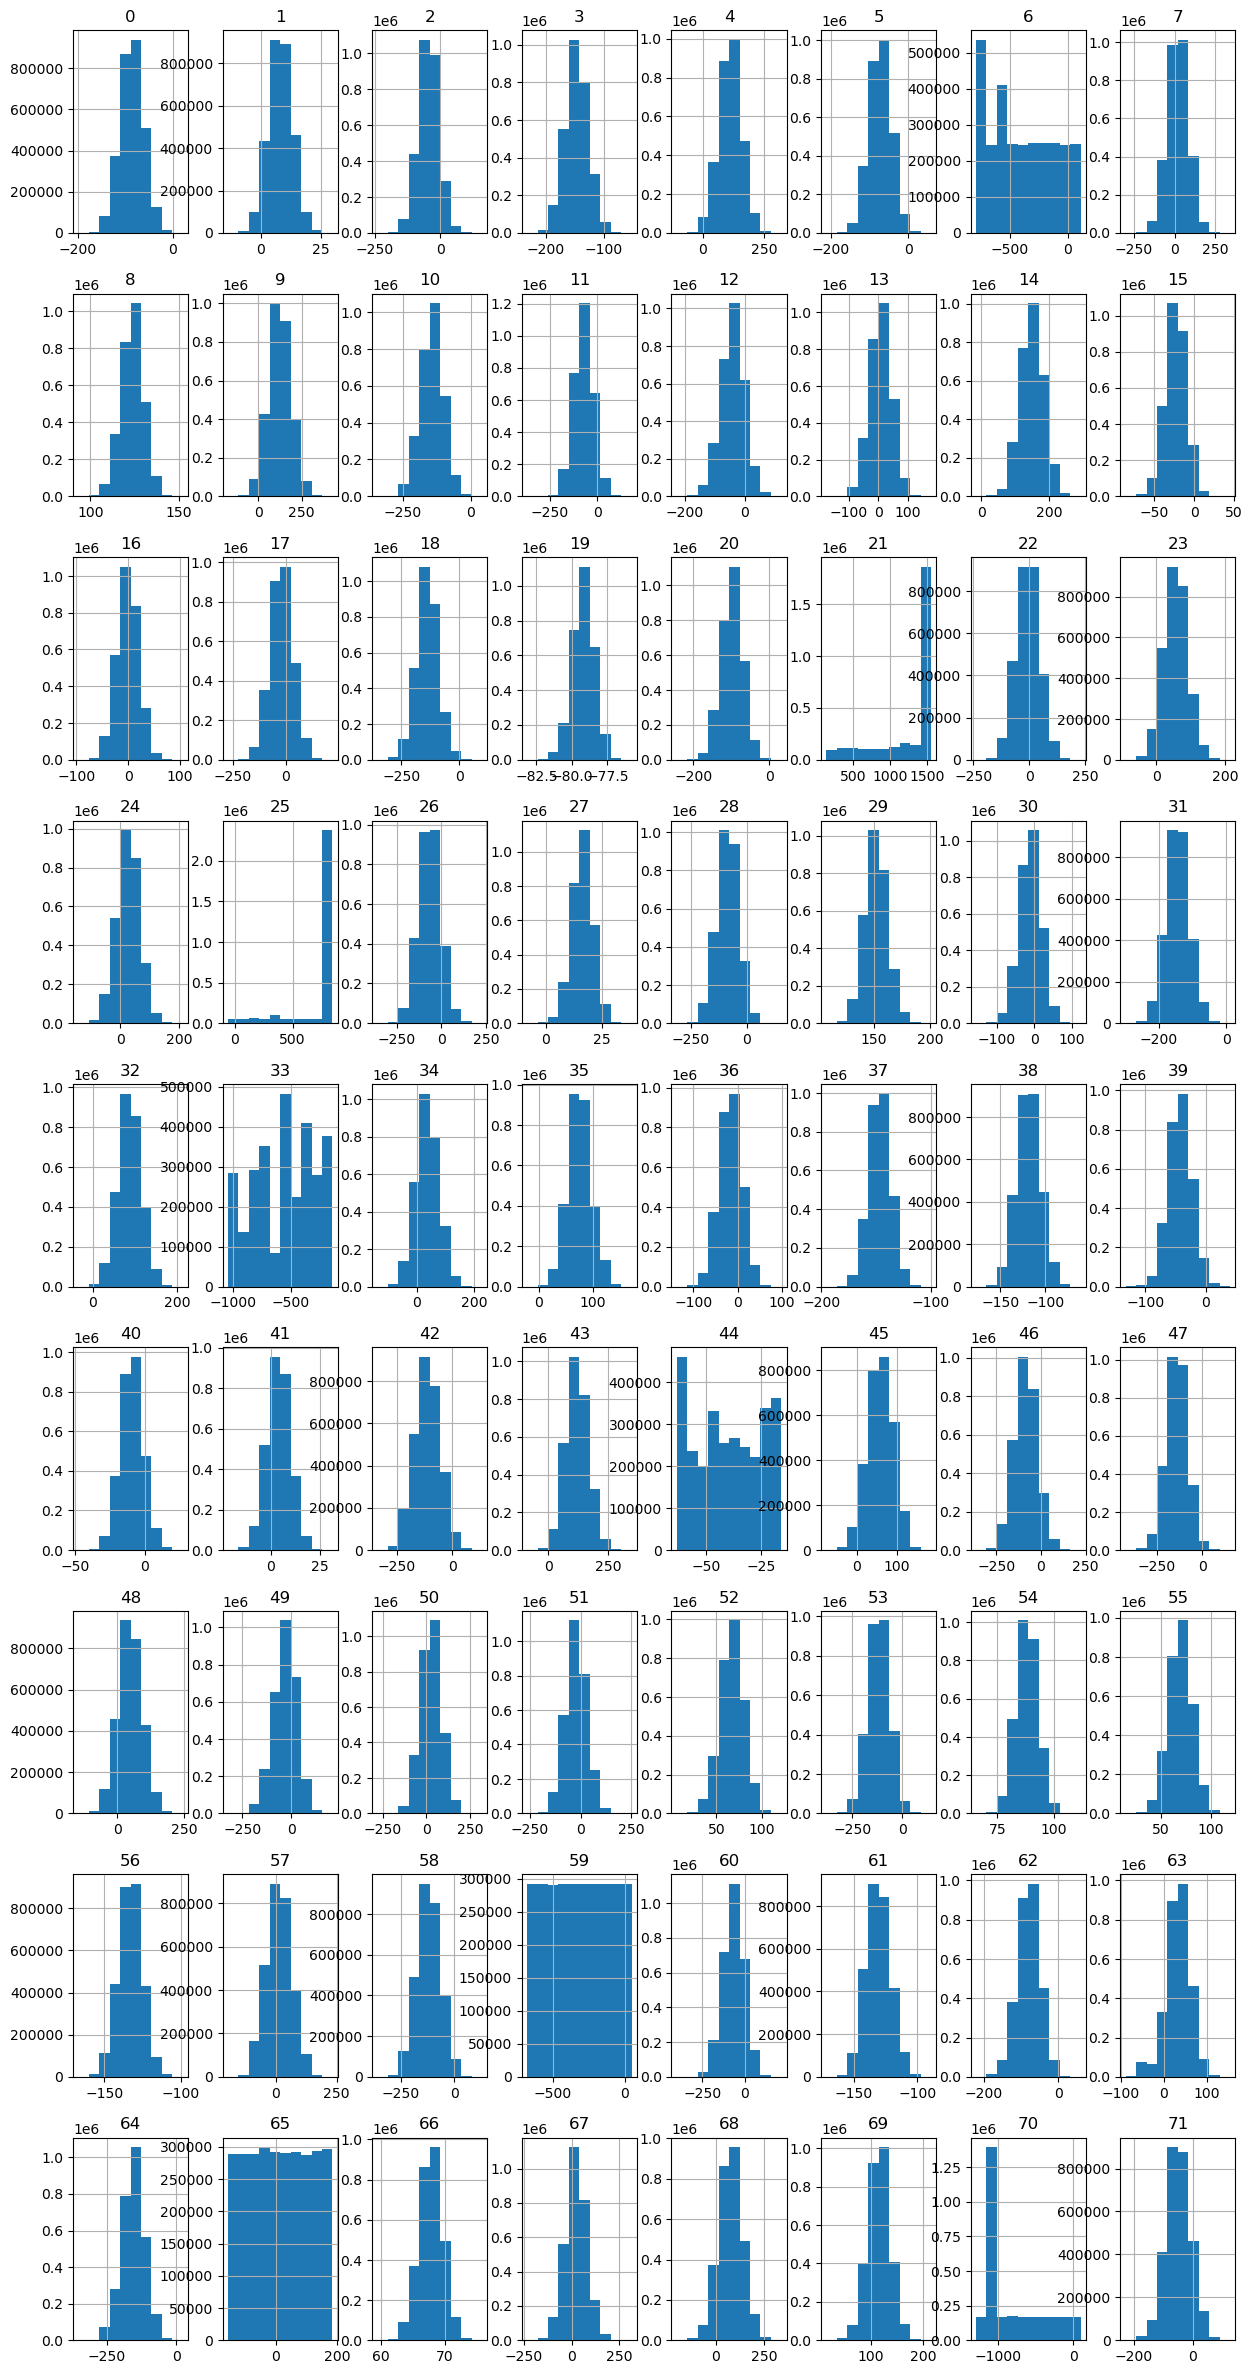

In [10]:
%%time
base.hist(figsize=(15, 30));

## Масштабирование

In [11]:
features=train.drop(['Target'] ,axis=1) 
targets=train["Target"]

In [12]:
scaler = StandardScaler()
base[:]=scaler.fit_transform(base[:]) 
base.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,0.884544,...,1.189049,0.190524,0.073589,-0.894789,-2.262494,-0.510438,0.293004,-0.014051,1.781420,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623904,1.098487,...,-1.272135,0.270119,-0.073570,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052


In [13]:
features[:]=scaler.transform(features[:])
features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.165148,0.279598,-2.296794,-1.459626,...,-0.866975,1.274319,-0.024409,-1.173481,-1.035386,0.197184,-0.200786,0.906575,0.995267,0.522963
1-query,-0.062146,-0.257159,0.324249,-1.543246,0.204684,-0.419328,1.095695,-1.538329,0.193777,0.246358,...,1.254600,-0.991073,0.075152,-0.159574,0.207971,0.028031,0.244774,0.709459,-0.611690,-0.083491


In [14]:
validation[:]=scaler.transform(validation[:])
validation.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,-0.253186,1.860318,-1.699665,-0.764269,...,0.115241,0.676228,0.275453,0.453765,0.817489,0.693550,0.597167,-0.020121,-0.777845,-1.659674
100001-query,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,-1.352459,0.679613,0.540216,-1.107069,...,-0.013756,-0.142349,-0.334949,-0.980522,1.631022,-1.617587,0.360549,0.369533,0.142436,0.545701


## Двухэтапная модель FAISS+CatBoost
Отберем кандидатов с помощью FAISS, затем ранжируем их помощью CatBoostClassifier и оставим топ-5 для расчета метрик.

**Гипотеза 1:** Двухэтапная модель FAISS+CatBoost (от 100 кандидатов на 1м этапе) даст не менее 75% точности

### Создание индексов

In [27]:
%%time 
dims = base.shape[1]   # размерность вектора признаков
n_cells = 36           # кол-во центроидов/кластеров для группировки                
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.train(np.ascontiguousarray(base.values[:100000, :]).astype('float32')) 
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))


CPU times: total: 3min 9s
Wall time: 18.2 s


### Отбор кандидатов FAISS 

In [ ]:
%%time 
#idx_l2.nprobe=6  # Проходим по топ-nprobe центроид для поиска top-k ближайших соседей
k=1050 #сколько ближайших соседей искать для каждого товара
vecs, idx = idx_l2.search(np.ascontiguousarray(features.values).astype('float32'), k)  

In [ ]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [ ]:
acc = 0
for target, el in tqdm(zip(targets.values.tolist(), idx.tolist())):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

#### Объединим кандидатов в DataFrame

In [27]:
def con_candidate(i,l,lnew,validation):
    for j in range(len(l)):
        lnew.append([i, validation.index[i],base_index[l[j]] ,j ])
    return lnew

In [28]:
lnew=[]
for i in tqdm(range(len(idx))):    
    lnew=con_candidate(i,idx[i],lnew,train)

df_t_new=pd.DataFrame(data=lnew,columns=['id_num','id_name','id_cand_name','rank'])
display(df_t_new.shape)
df_t_new.head(4)

100%|██████████| 100000/100000 [00:11<00:00, 8591.71it/s]


(10000000, 4)

,id_num,id_name,id_cand_name,rank
0,0,0-query,675816-base,0
1,0,0-query,877519-base,1
2,0,0-query,361564-base,2
3,0,0-query,2725256-base,3


#### Добавим признаки

Добавим целевой признак.
Заполним колонку **"ground truth"**, где будет 1 - если товар-кандидат совпал с товаром, отмеченным экспертом, и 0 - в противном случае
Эта колонка будет целевой признак при обучении второй модели


In [29]:
%%time
#присоединим 'Target':  
df=pd.merge(df_t_new, train[['Target']], how='left', left_on='id_name', right_on=train.index) 

df['ground truth']=df["id_cand_name"]==df["Target"]
df['ground truth']=df['ground truth'].apply(lambda x: int(x))
df=df.drop(['Target'],axis=1)
df.head(2)

CPU times: total: 7.45 s
Wall time: 7.45 s


,id_num,id_name,id_cand_name,rank,ground truth
0,0,0-query,675816-base,0,1
1,0,0-query,877519-base,1,0


 Добавим признаки товарам

In [30]:
#присоединим хар-ки основного товара:
df=pd.merge(df, features, how='left', left_on='id_name', right_on=features.index)  

#присоединим хар-ки кандидатов
df=pd.merge(df, base.add_suffix('_cand'), how='left', left_on='id_cand_name', right_on=base.index)
df.head(2)

,id_num,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,0,0-query,675816-base,0,1,1.299518,1.996888,0.063774,-1.87967,1.644099,...,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902
1,0,0-query,877519-base,1,0,1.299518,1.996888,0.063774,-1.87967,1.644099,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560


### Формирование датасетов для обучения катбуста

In [33]:
df_mini=df                   
df_mini=df_mini.loc[:,'id_name':]

display(df_mini.shape)
df_mini.head(1)

(10000000, 148)

,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,5,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,0-query,675816-base,0,1,1.299518,1.996888,0.063774,-1.87967,1.644099,-0.537626,...,-0.927103,1.627806,0.072924,0.42746,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902


In [34]:
feat_col=df_mini.columns.to_list()  #список колонок с признаками, для катбуста
feat_col=feat_col[2:]
feat_col.remove('ground truth')
len(feat_col)

145

In [35]:
features_train_m=df_mini[:9000000]
features_test_m=df_mini[9000000:10000000]
print(features_train_m.shape, ';', features_test_m.shape)

(9000000, 148) ; (1000000, 148)


In [36]:
features_train_m[feat_col].head(4)

,rank,0,1,2,3,4,5,6,7,8,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,0,1.299518,1.996888,0.063774,-1.87967,1.644099,-0.537626,0.165148,0.279598,-2.296794,...,-0.927103,1.627806,0.072924,0.427460,-0.496641,0.394758,-0.568302,0.066837,0.995267,0.708902
1,1,1.299518,1.996888,0.063774,-1.87967,1.644099,-0.537626,0.165148,0.279598,-2.296794,...,-0.676032,1.615281,-0.247046,-0.404396,-1.148503,0.412697,-0.375744,0.728224,0.544932,0.270560
2,2,1.299518,1.996888,0.063774,-1.87967,1.644099,-0.537626,0.165148,0.279598,-2.296794,...,-0.332150,1.723392,-0.369458,0.988497,-1.100242,0.280916,-0.492041,0.532096,0.543575,0.090279
3,3,1.299518,1.996888,0.063774,-1.87967,1.644099,-0.537626,0.165148,0.279598,-2.296794,...,-0.514269,2.073714,-0.360444,-0.335696,-1.196697,0.156157,-1.269117,0.007341,1.964740,0.834797


### Сгенерируем новые признаки

### Обучение CatBoostClassifier 

Используем CatBoostClassifier для ранжирования кандидатов.В качестве ранга возьмем вероятность принадлежности к классу 1, запишем ее в колонку "cb_proba".

Так как, выборка получилась сильно несбалансированная, при обучении используем аргумент class_weights. Соотношение возьмем пропорционально числу кандидатов, так как верный - максимум один из всех

In [37]:
target_mini=df_mini[['ground truth']]
target_train_m=target_mini[:9000000]
target_test_m=target_mini[9000000:10000000]
print(target_train_m.shape, ';', features_test_m.shape)

(9000000, 1) ; (1000000, 148)


In [38]:
%%time

model = CatBoostClassifier(iterations=352,learning_rate=0.5, class_weights=(1, k-1))  #k - ckolko candidatov learning_rate=0.1,

model.fit(features_train_m[feat_col],
              target_train_m,
              eval_set=(features_test_m[feat_col],target_test_m),
              plot=True,
              verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3262340	test: 0.3272063	best: 0.3272063 (0)	total: 1.89s	remaining: 11m 4s
100:	learn: 0.1110341	test: 0.1228231	best: 0.1227945 (99)	total: 2m 45s	remaining: 6m 51s
200:	learn: 0.0893961	test: 0.1154564	best: 0.1152796 (179)	total: 5m 16s	remaining: 3m 57s
300:	learn: 0.0763934	test: 0.1138013	best: 0.1134068 (271)	total: 7m 40s	remaining: 1m 17s
351:	learn: 0.0710589	test: 0.1138686	best: 0.1130131 (326)	total: 8m 53s	remaining: 0us

bestTest = 0.113013112
bestIteration = 326

Shrink model to first 327 iterations.
CPU times: total: 1h 39min 8s
Wall time: 10min 1s


In [40]:
features_test_m["cb_proba"] = model.predict_proba(features_test_m[feat_col])[:,1]
features_test_m.head(1)

,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,5,...,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand,cb_proba
9000000,90000-query,580695-base,0,1,-0.096124,-0.305887,-1.955077,-0.633086,0.027612,-0.547764,...,-1.257435,1.077438,1.091585,-1.866497,-0.985299,-0.620539,-0.484287,0.371964,-0.054024,0.999098


75.52   74.89 73.7 72.6

### Тест на validation

In [44]:
expected=validation_answer['Expected']

In [46]:
validation.shape

(100000, 72)

In [47]:
validation_answer.head(2)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base


#### Отбор кандидатов FAISS 

In [48]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(validation.values).astype('float32'), k)  

CPU times: total: 1h 56min 33s
Wall time: 10min 11s


#### Объединим кандидатов в DataFrame

In [49]:
lnew=[]
for i in tqdm(range(len(idx))):   
    lnew=con_candidate(i,idx[i],lnew,validation)

df_t_new=pd.DataFrame(data=lnew,columns=['id_num','id_name','id_cand_name','rank'])
display(df_t_new.shape)
df_t_new.head(4)

100%|██████████| 100000/100000 [00:11<00:00, 8367.44it/s]


(10000000, 4)

,id_num,id_name,id_cand_name,rank
0,0,100000-query,3209652-base,0
1,0,100000-query,3181043-base,1
2,0,100000-query,368296-base,2
3,0,100000-query,645855-base,3


In [50]:
df_t_new.sample(6)

,id_num,id_name,id_cand_name,rank
6061372,60613,160613-query,4245936-base,72
9943457,99434,199434-query,3876475-base,57
4420617,44206,144206-query,4281618-base,17
4291146,42911,142911-query,1373486-base,46
7156902,71569,171569-query,858688-base,2
5150533,51505,151505-query,2266722-base,33


#### Добавим признаки

In [51]:
%%time 
#присоединим 'Target':  
df=pd.merge(df_t_new, validation_answer[['Expected']], how='left', left_on='id_name', right_on=validation_answer.index) 

CPU times: total: 1.53 s
Wall time: 1.59 s


In [52]:
%%time
df['ground truth']=df["id_cand_name"]==df["Expected"]
df['ground truth']=df['ground truth'].apply(lambda x: int(x))
df=df.drop(['Expected'],axis=1)
df.head(2)

CPU times: total: 5.86 s
Wall time: 5.86 s


,id_num,id_name,id_cand_name,rank,ground truth
0,0,100000-query,3209652-base,0,0
1,0,100000-query,3181043-base,1,0


In [53]:
#присоединим хар-ки основного товара:
df=pd.merge(df, validation, how='left', left_on='id_name', right_on=validation.index)  

#присоединим хар-ки кандидатов
df=pd.merge(df, base.add_suffix('_cand'), how='left', left_on='id_cand_name', right_on=base.index)
df.head(2)

,id_num,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,0,100000-query,3209652-base,0,0,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.457505,0.948873,0.570802,1.213205,0.909869,0.897679,0.018913,0.430446,-0.713847,-1.182590
1,0,100000-query,3181043-base,1,0,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.190811,0.477240,-0.017377,0.170011,0.557127,0.766064,0.048265,0.406470,-0.713847,-1.284064


#### Ранжирование

In [54]:
features_test_m=df
features_test_m["cb_proba"] = model.predict_proba(features_test_m[feat_col])[:,1]
features_test_m.head(1)

,id_num,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,...,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand,cb_proba
0,0,100000-query,3209652-base,0,0,1.15931,-0.904901,0.811955,1.043508,-0.012313,...,0.948873,0.570802,1.213205,0.909869,0.897679,0.018913,0.430446,-0.713847,-1.18259,0.869793


In [55]:
#оставим только важные столбцы
dff=features_test_m[['id_name','id_cand_name','rank','cb_proba','ground truth']]
dff.head(2)

,id_name,id_cand_name,rank,cb_proba,ground truth
0,100000-query,3209652-base,0,0.869793,0
1,100000-query,3181043-base,1,0.489031,0


In [56]:
dff_table=dff.sort_values(['id_name','cb_proba'],ascending=False).groupby('id_name').head(5) # отсортируем по убыванию  
display(dff_table.shape)
dff_table.head(6)

(500000, 5)

,id_name,id_cand_name,rank,cb_proba,ground truth
9999900,199999-query,4678196-base,0,0.696112,0
9999901,199999-query,3842322-base,1,0.517459,0
9999905,199999-query,2503531-base,5,0.208767,0
9999921,199999-query,541580-base,21,0.088373,0
9999919,199999-query,336472-base,19,0.054968,1
9999800,199998-query,341779-base,0,0.998703,1


#### Расчет метрики

Для расчета метрики, отсортируем кандидатов по вероятности и возьмем топ-5. Затем, можно просто проссумировать единички с колонки "ground truth" и поделить на количество товаров

In [57]:
acc5=(dff_table['ground truth'].sum())/ (len(dff_table)/5) *100 # среднее число единиц на каждую пятерку строк, в % 
acc5

73.996

## Выводы:

Разработали двух-этапную модель. На первом этапе отобрали 100 кандидатов. Из которых, с пмощью катбуста выбрали 5 лучших. Добились хорошей метрики 73.996 %
